#    Проект "Определяющие успешность игры закономерности"

# План
1. Открыть файл с данными и изучить общую информацию.
2. Предобработать данные.
3. Провести исследовательский анализ данных.
4. Составить портрет пользователя каждого региона.
5. Проверить гипотезы.
6. Общий вывод

## Изучим общую информацию.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st    

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Столбец Year_of_Release нужно привести к типу int. User_Score привести к типу float. Critic_Score к int. 
Привести названия столбцов к  нижнему регистру.  
Обработать пропуски

## Предобработка

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

**Обработаем пропуски.**

In [7]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [8]:
df[df['name'].isna()]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [9]:
# удалим две строки с множеством пропущенных значений
df = df.dropna(subset=['name']).reset_index(drop=True)
df['name'].isna().sum()

0

In [10]:
df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16371,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16403,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16446,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16456,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


У некоторых игр в жанре sport/racing/fighting в названии есть год выпуска. Составим код, который заполнит пропуски исходя из названия.

In [11]:
def fill_year(row):
    year = 0
    last_word = ''
    genre = row[3]
    
    # Поиск года в строке
    for word in row[0].split():
        if word.isdigit():
            year = int(word)
        last_word = word
    
    # Проверка жанра и условий
    if genre in ('Sports', 'Racing', 'Fighting'):
        if year > 2000 or last_word in ('2K6', '2K8'):
            if genre == 'Sports':
                year -= 1
            if last_word == '2K6':
                year = 2006
            elif last_word == '2K8':
                year = 2008
            # Заполнение года, если значение NaN
            if year < 2017 and pd.isna(row[2]):
                row[2] = year
    
    return row
df = df.apply(fill_year,axis=1)


In [12]:
df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
677,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
...,...,...,...,...,...,...,...,...,...,...,...
16346,Agarest Senki: Re-appearance,PS3,NaN,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16403,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16446,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16456,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [13]:
#удалось заполнить 18 строк, остальные может удалить
df = df.dropna(subset=['year_of_release']).reset_index(drop=True)
df['year_of_release'].isna().sum()

0

In [14]:
df[df['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16457,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16458,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16459,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16460,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Пропуски в столбцах 'crilic_score' & 'user_score' это субъективное мнение об игре, нельзя заполнить медианой или средним значением.  
Можно предположить, что пропуски появились из-за некорректной выгрузки данных.  
Тяжело оценить возрастной рейтинг игры(rating) исходя из названия и жанра. Оставим пропуски.

**Изменим тип данных.**

In [15]:
df['year_of_release'] = pd.to_numeric(df['year_of_release'],downcast='integer') # год выпуска это целое число
df['user_score'] = df['user_score'].replace('tbd', np.NaN)
df['user_score'] = pd.to_numeric(df['user_score'], downcast='float', errors ='coerce')# оценка пользователей этой число
df['user_score'] = df['user_score'].round(1)
df['critic_score'] = np.floor(pd.to_numeric(df['critic_score'], errors='coerce')).astype('Int64')# оценка критиков это целое число

Значение 'tbd' означает, что сейчас идет оценивание и по факту оценки нет, поэтому все "tbd" можно заменить на NaN.

In [16]:
df.dtypes


name                object
platform            object
year_of_release      int16
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score         Int64
user_score         float32
rating              object
dtype: object

Добавим столбец суммарные продажи во всех регионах

In [17]:
df['total_sales'] = df.loc[:,['na_sales','eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN,31.38


**Промежуточный вывод:**  
- Привели названия столбцов к нижнему регистру
- Восстановлены пропуски в строках
- Удалены пустые строки
- Добавили столбец суммарных продаж

## Исследовательский анализ

### *Cколько игр выпускалось в разные годы. Важны ли данные за все периоды?*

In [18]:
year_pivot = pd.pivot_table(df, index='year_of_release', values='name', aggfunc='count')
year_pivot.columns = ['games_count']
year_pivot

,games_count
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


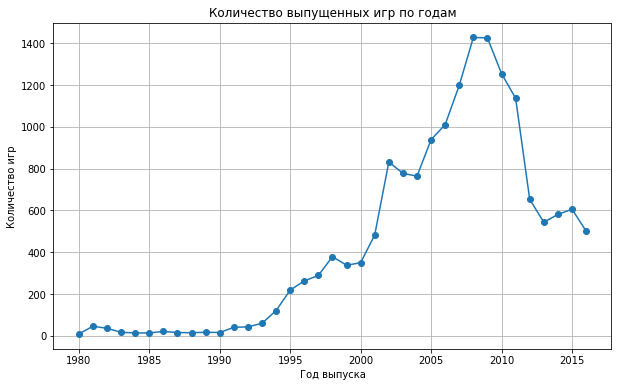

In [19]:
plt.figure(figsize=(10,6))
plt.plot(year_pivot.index, year_pivot['games_count'], marker='o')
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.grid(True)
plt.show()

Данные с 1980г. по 1994г не так важны.  
В 2002г выпустили много игр. Рост числа выпуска игр приходится на 1995 год, с максимумом примерно в 2008 году после чего прослеживается спад.   
С 2012 года объем выпуска игр стабилизировался и год от года отличается несильно.

### Как менялись продажи по платформам. Определить платформы с наибольшими суммарными продажами и построить распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

,total_sales
platform,
PS2,1247.53
X360,961.30
PS3,931.34
Wii,891.18
DS,802.79
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.69


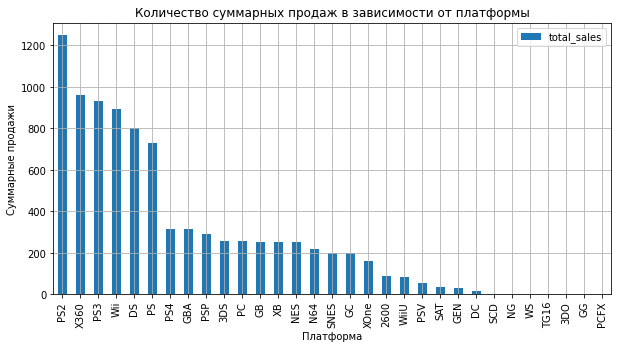

In [20]:
platform_pivot = (df.pivot_table(index=['platform'], values='total_sales', aggfunc='sum')
                  .sort_values('total_sales',ascending=False))
display(platform_pivot)
platform_pivot.plot(kind='bar' , grid=True, figsize=(10, 5))
plt.title('Количество суммарных продаж в зависимости от платформы')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи')
plt.show()
                                

Рассмотрим топ 6 платформ по продажам.

In [21]:
top_sales = list(platform_pivot.index[:6])
top_sales

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

In [22]:
for platform in top_sales:
    print('Платформа ',platform)
    top_sales_pivot = pd.pivot_table(df.query('platform == @platform'), index=['platform','year_of_release'], values='total_sales', aggfunc='sum')
    print(top_sales_pivot)
    print()

Платформа  PS2
                          total_sales
platform year_of_release             
PS2      2000                   39.17
         2001                  166.43
         2002                  205.78
         2003                  194.27
         2004                  212.13
         2005                  160.66
         2006                  106.71
         2007                   75.99
         2008                   53.90
         2009                   26.40
         2010                    5.64
         2011                    0.45

Платформа  X360
                          total_sales
platform year_of_release             
X360     2005                    8.25
         2006                   51.63
         2007                   95.41
         2008                  135.26
         2009                  120.29
         2010                  170.03
         2011                  143.89
         2012                   99.74
         2013                   88.58
         2014     

Платформа PS2


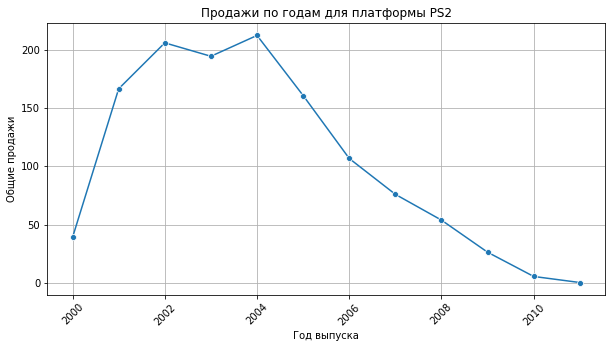

Платформа X360


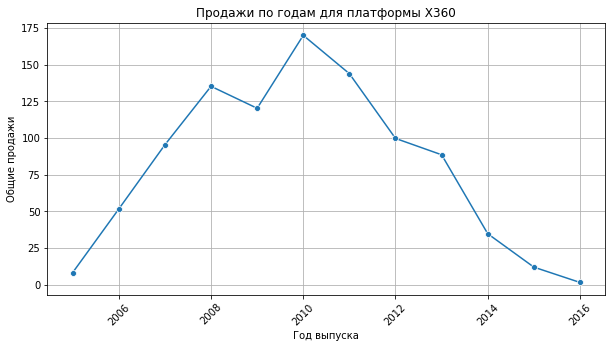

Платформа PS3


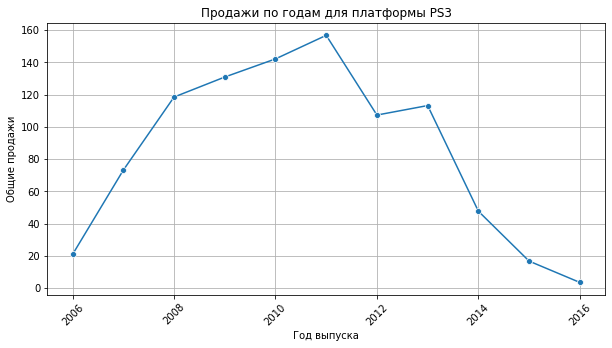

Платформа Wii


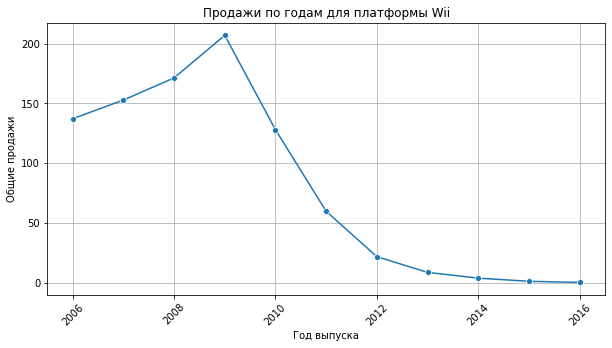

Платформа DS


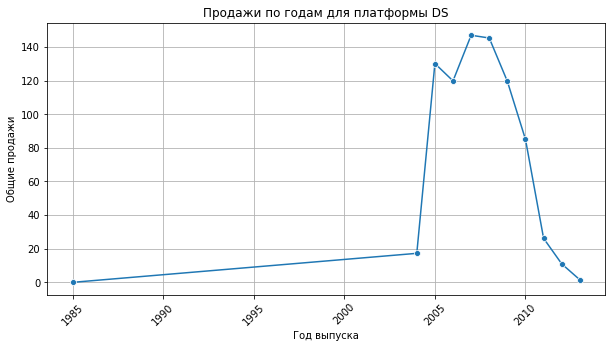

Платформа PS


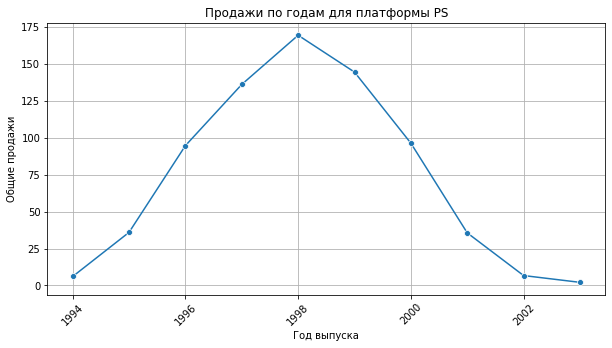

In [23]:
for platform in top_sales:
    print(f'Платформа {platform}')
    top_sales_pivot = pd.pivot_table(df.query('platform == @platform'), 
                                     index='year_of_release', 
                                     values='total_sales', 
                                     aggfunc='sum')

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=top_sales_pivot, x=top_sales_pivot.index, y='total_sales', marker='o')
    
    plt.title(f'Продажи по годам для платформы {platform}')
    plt.xlabel('Год выпуска')
    plt.ylabel('Общие продажи')
    plt.grid(True)
    plt.xticks(rotation=45)
    
    plt.show()

In [24]:
(df.groupby('platform')['year_of_release'].max() - df.groupby('platform')['year_of_release'].min()).mean()

7.612903225806452

In [25]:
(df.groupby('platform')['year_of_release'].max() - df.groupby('platform')['year_of_release'].min()).median()


6.0

Средняя продолжительность жизни платформы 7.6 лет, а медианнная 6.0 лет.

### Возьмем данные за соответствующий актуальный период 2012-2016.


In [26]:
actual_platforms = (df
    .query('year_of_release > 2011')
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .reset_index().head(10)['platform'].tolist()
    )                         
actual_platforms

['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii', 'DS']

In [27]:
actual_df = df.query('year_of_release > 2011').copy().reset_index(drop= True)
actual_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,<NA>,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,<NA>,NaN,NaN,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83,5.3,M,13.79


In [28]:
#самые прибыльные платформы
best_platform = actual_df.pivot_table(index=['platform','year_of_release'],values='total_sales',aggfunc='sum')
best_platform

total_sales
platform year_of_release             
3DS      2012                   51.36
         2013                   56.57
         2014                   43.76
         2015                   27.78
         2016                   15.14
DS       2012                   11.01
         2013                    1.54
PC       2012                   23.22
         2013                   12.38
         2014                   13.28
         2015                    8.52
         2016                    5.25
PS3      2012                  107.36
         2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2013                   25.99
         2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2012                    7.69
         2013                    3.14
         2014                    0.24
         2015                    0.12
PSV      2012                   16.19
         2013                   10.59
         2014                   11.90
         2015                    6.25
         2016                    4.25
Wii      2012                   21.71
         2013                    8.59
         2014                    3.75
         2015                    1.14
         2016                    0.18
WiiU     2012                   17.56
         2013                   21.65
         2014                   22.03
         2015                   16.35
         2016                    4.60
X360     2012                   99.74
         2013                   88.58
         2014                   34.74
         2015                   11.96
         2016                    1.52
XOne     2013                   18.96
         2014                   54.07
         2015                   60.14
         2016                   26.15

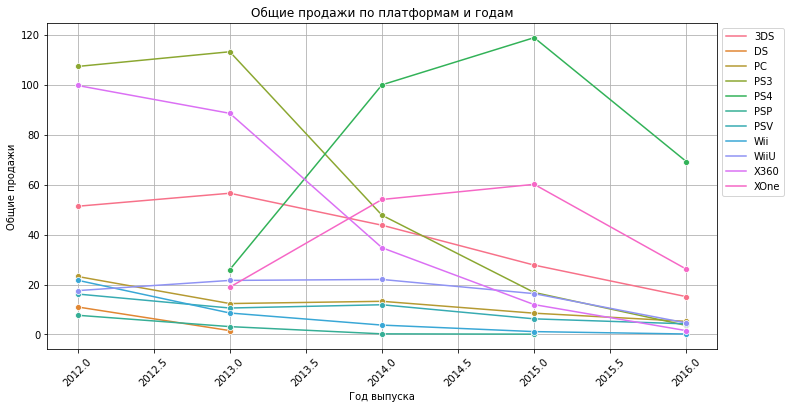

In [29]:
plt.figure(figsize=(12, 6))
best_platform_reset = best_platform.reset_index()
sns.lineplot(data=best_platform_reset, x='year_of_release', y='total_sales', hue='platform', marker='o')


plt.title('Общие продажи по платформам и годам')
plt.xlabel('Год выпуска')
plt.ylabel('Общие продажи')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

PS4 смещает лидера PS3 и становится самой перспективной платформой в выбранном периоде.

In [30]:
best_platform = actual_df.pivot_table(index=['platform'],values='total_sales',aggfunc='sum')
best_platform.sort_values('total_sales',ascending=False)


,total_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18
Wii,35.37


Топ 5 платформ: PS4,PS3,X360,3DS,XOne.  
Продажи PS4, XOne, 3DS, WiiU и PSV демонстрируют рост, так как эти консоли сменяют приставки предыдущего поколения. В то же время наблюдается снижение продаж предыдущего поколения консолей, таких как PS3, X360, DS, Wii и PSP. Также отмечается рост продаж на платформе PC.

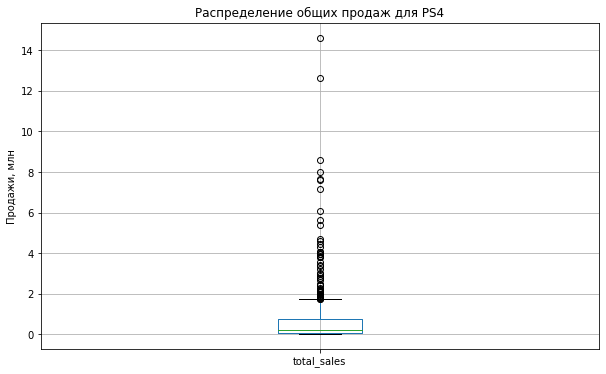

In [31]:
plt.figure(figsize=(10, 6))
actual_df[actual_df['platform'] == 'PS4'].boxplot('total_sales')
plt.ylabel('Продажи, млн')
plt.title('Распределение общих продаж для PS4')
plt.show()

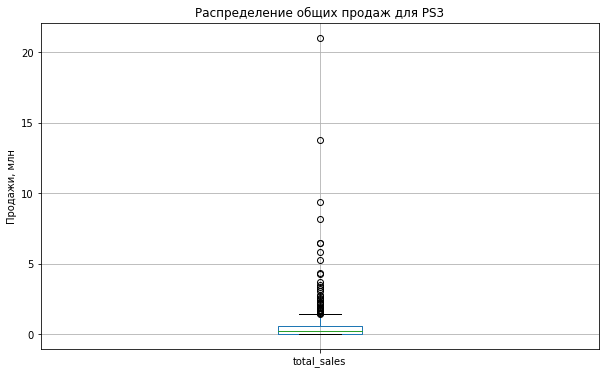

In [32]:
plt.figure(figsize=(10, 6))
actual_df[actual_df['platform'] == 'PS3'].boxplot('total_sales')
plt.ylabel('Продажи, млн')
plt.title('Распределение общих продаж для PS3')
plt.show()

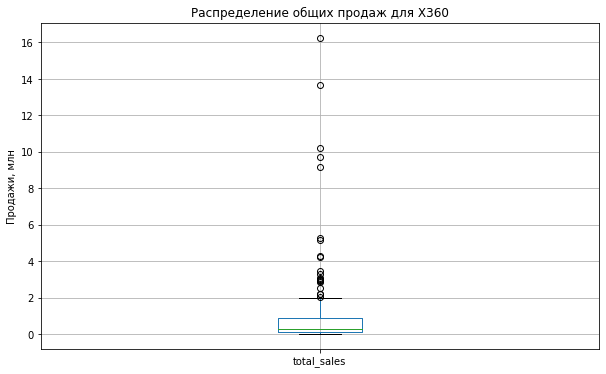

In [33]:
plt.figure(figsize=(10, 6))
actual_df[actual_df['platform'] == 'X360'].boxplot('total_sales')
plt.ylabel('Продажи, млн')
plt.title('Распределение общих продаж для X360')
plt.show()

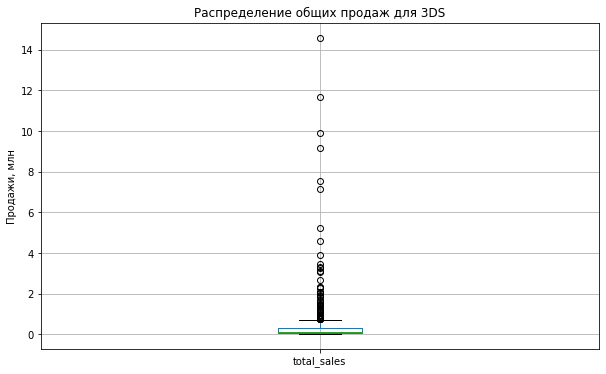

In [34]:
plt.figure(figsize=(10, 6))
actual_df[actual_df['platform'] == '3DS'].boxplot('total_sales')
plt.ylabel('Продажи, млн')
plt.title('Распределение общих продаж для 3DS')
plt.show()

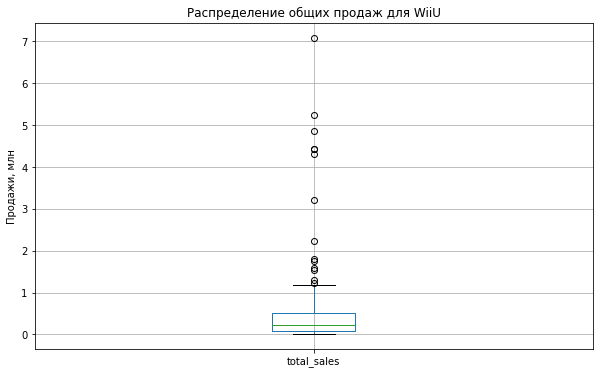

In [35]:
plt.figure(figsize=(10, 6))
actual_df[actual_df['platform'] == 'WiiU'].boxplot('total_sales')
plt.ylabel('Продажи, млн')
plt.title('Распределение общих продаж для WiiU')
plt.show()

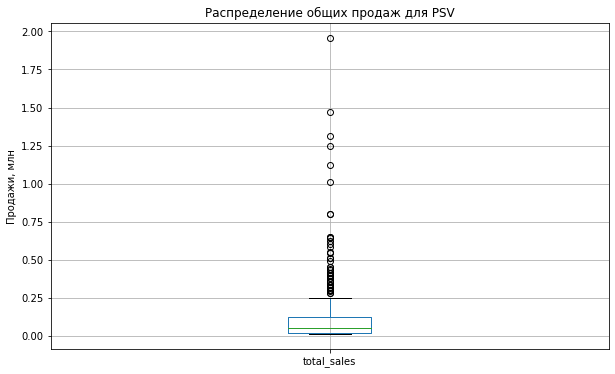

In [36]:
plt.figure(figsize=(10, 6))
actual_df[actual_df['platform'] == 'PSV'].boxplot('total_sales')
plt.ylabel('Продажи, млн')
plt.title('Распределение общих продаж для PSV')
plt.show()

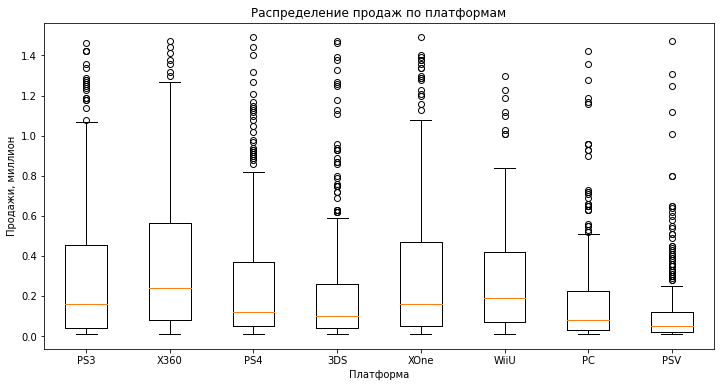

In [37]:
platforms = ['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'PC', 'PSV']

plt.figure(figsize=(12, 6))

data_to_plot = [actual_df.loc[(actual_df['platform'] == platform) & (actual_df['total_sales'] < 1.5), 'total_sales'] for platform in platforms]

plt.boxplot(data_to_plot, labels=platforms)

plt.title('Распределение продаж по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи, миллион')
plt.show()

Динамика продаж у всех платформ схожа — основной диапазон большинства продаж находится в пределах до 200 тыс., при этом присутствуют длинные хвосты. Наиболее равномерное распределение наблюдается у платформы WiiU. Наибольшие продажи зафиксированы у XOne и PS4, в то время как медианные продажи выше у X360 и WiiU.

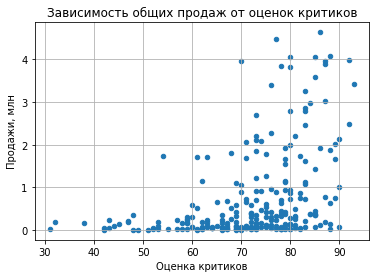

In [38]:
actual_df.query('platform == "PS4" and total_sales < 5 and critic_score > 30')\
    .plot.scatter(x='critic_score', y='total_sales', grid=True)

plt.title('Зависимость общих продаж от оценок критиков')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи, млн')
plt.show()

In [39]:
actual_df.query('platform == "PS4" and total_sales < 5 and critic_score > 30')\
           .loc[:, ['critic_score', 'total_sales']].corr()


,critic_score,total_sales
critic_score,1.000000,0.410449
total_sales,0.410449,1.000000


Корреляция положительная, но не сильная. Высокая оценка критиков не всегда гарантирует успех в продажах.


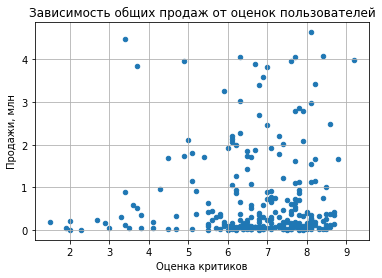

In [40]:
actual_df.query('platform == "PS4" and total_sales < 5')\
    .plot.scatter(x='user_score', y='total_sales', grid=True)

plt.title('Зависимость общих продаж от оценок пользователей')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи, млн')
plt.show()

In [41]:
actual_df.query('platform == "PS4" and total_sales < 5')\
           .loc[:, ['user_score', 'total_sales']].corr()

,user_score,total_sales
user_score,1.00000,0.01458
total_sales,0.01458,1.00000


Оценки пользователей не влияют на продажу игры. Посмотрим на другие платформы.

In [42]:
for platform in ['X360', 'PS3', '3DS', 'WiiU', 'PC', 'PSV', 'XOne']:
    print(platform)
    
    crit_sales_corr = actual_df.query('platform == @platform and total_sales < 5 and critic_score > 30')\
                        .loc[:, ['critic_score', 'total_sales']].corr()
    
    user_sales_corr = actual_df.query('platform == @platform and total_sales < 5 and critic_score > 30')\
                        .loc[:, ['user_score', 'total_sales']].corr()
    
    print(crit_sales_corr)
    print(user_sales_corr)
    print()

X360
              critic_score  total_sales
critic_score      1.000000     0.492371
total_sales       0.492371     1.000000
             user_score  total_sales
user_score     1.000000     0.127673
total_sales    0.127673     1.000000

PS3
              critic_score  total_sales
critic_score      1.000000     0.459079
total_sales       0.459079     1.000000
             user_score  total_sales
user_score     1.000000     0.118783
total_sales    0.118783     1.000000

3DS
              critic_score  total_sales
critic_score      1.000000     0.359583
total_sales       0.359583     1.000000
             user_score  total_sales
user_score     1.000000     0.242963
total_sales    0.242963     1.000000

WiiU
              critic_score  total_sales
critic_score      1.000000     0.334658
total_sales       0.334658     1.000000
             user_score  total_sales
user_score     1.000000     0.374552
total_sales    0.374552     1.000000

PC
              critic_score  total_sales
critic_scor

- В целом, для большинства платформ корреляция между оценками критиков и продажами умеренная или слабая, что указывает на то, что высокая оценка критиков не всегда приводит к высоким продажам.
- Корреляция между пользовательскими оценками и продажами в целом еще слабее, что говорит о минимальном влиянии пользовательских оценок на продажи.

**Рассмотрим распределение по жанрам игр.**

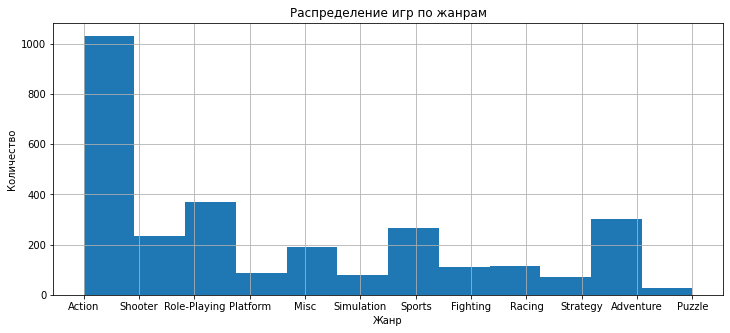

In [43]:
actual_df['genre'].hist(bins=12, figsize=(12,5))
plt.xlabel('Жанр')
plt.ylabel('Количество')
plt.title('Распределение игр по жанрам')
plt.show()

Больше всего игр в жанре Action

In [44]:
actual_df.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

genre
Action          441.12
Shooter         304.73
Role-Playing    192.80
Sports          181.07
Misc             85.04
Platform         61.00
Racing           53.50
Fighting         44.49
Simulation       35.12
Adventure        29.43
Strategy         13.34
Puzzle            4.89
Name: total_sales, dtype: float64

Больше всего продаж тоже в жанре Action

In [45]:
actual_df.groupby('genre')['total_sales'].mean().sort_values(ascending=False)

genre
Shooter         1.296723
Platform        0.717647
Sports          0.675634
Role-Playing    0.521081
Racing          0.465217
Misc            0.442917
Simulation      0.439000
Action          0.427856
Fighting        0.408165
Strategy        0.187887
Puzzle          0.174643
Adventure       0.097450
Name: total_sales, dtype: float64

In [46]:
actual_df.groupby('genre')['total_sales'].median().sort_values(ascending=False)

genre
Shooter         0.440
Sports          0.240
Platform        0.210
Role-Playing    0.140
Racing          0.140
Fighting        0.130
Action          0.120
Misc            0.120
Simulation      0.120
Strategy        0.080
Puzzle          0.045
Adventure       0.030
Name: total_sales, dtype: float64

Самые прибыльные жанры Shooter,Sports,Platform. Хуже всего продаются игры в жанрах Adventure,Puzzle,Straregy

## Пользователи разных регионов

### Самые популярные платформы.


In [47]:
pd.pivot_table(actual_df, index='platform', values='na_sales',
                                        aggfunc='sum').sort_values('na_sales', ascending=False)

,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31
WiiU,38.10
PC,19.12
Wii,17.45
PSV,10.98


In [48]:
pd.pivot_table(actual_df, index='platform', values='eu_sales',
                                        aggfunc='sum').sort_values('eu_sales', ascending=False)

,eu_sales
platform,
PS4,141.09
PS3,106.86
X360,74.52
XOne,51.59
3DS,42.64
PC,37.76
WiiU,25.13
Wii,11.92
PSV,11.36


In [49]:
pd.pivot_table(actual_df, index='platform', values='jp_sales',
                                        aggfunc='sum').sort_values('jp_sales', ascending=False)

,jp_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.04
PS4,15.96
WiiU,13.01
PSP,10.47
DS,3.72
Wii,3.39
X360,1.57


Рейтинг платформ:  
- Северная Америка: X360,PS4,PS3,XOne,3DS
- Европейский регион: PS4,PS3,X360,XOne,3DS
- Япония: 3DS,PS3,PSV,PS4,WiiU

1. Северная Америка:  
Лидером является X360, за ним следуют PS4 и PS3. Это показывает сильную популярность консолей Microsoft и Sony в данном регионе.  
XOne занимает четвёртую позицию, что говорит о том, что, несмотря на доминирование предыдущего поколения (X360), новое поколение консолей Microsoft также получило значительное внимание.  
3DS на пятом месте, что указывает на популярность портативных консолей в Северной Америке, но с меньшим влиянием по сравнению с домашними консолями.  


2. Европейский регион:  
В Европе доминирует PS4, за ним идут PS3 и X360, что указывает на значительную популярность консолей Sony. PS4 явно сильнее в Европе, чем в Северной Америке.  
XOne занимает четвёртое место, уступая X360, что отражает схожую картину с Северной Америкой.  
3DS также входит в топ-5, но её влияние меньше, чем в Японии.


3. Япония:  
В Японии доминируют портативные консоли, с 3DS на первом месте и PSV на третьем, что показывает предпочтение японских игроков к мобильному игровому опыту.  
Домашние консоли от Sony также популярны, с PS3 на втором месте и PS4 на четвёртом, однако их влияние значительно меньше, чем в Северной Америке и Европе.  
WiiU от Nintendo занимает пятую позицию, отражая популярность компании в Японии.  


4. Общий вывод:  
Sony доминирует на всех трёх рынках, особенно в Европе, где PS4 и PS3 занимают первые места.
Microsoft значительно сильнее в Северной Америке, где X360 занимает первое место, а XOne — четвёртое. В Европе их влияние также заметно, хотя в Японии Microsoft практически отсутствует.
Nintendo наиболее успешно в Японии, с 3DS на первом месте и WiiU на пятом. В Северной Америке и Европе портативные консоли от Nintendo также популярны, но менее влиятельны по сравнению с домашними консолями.

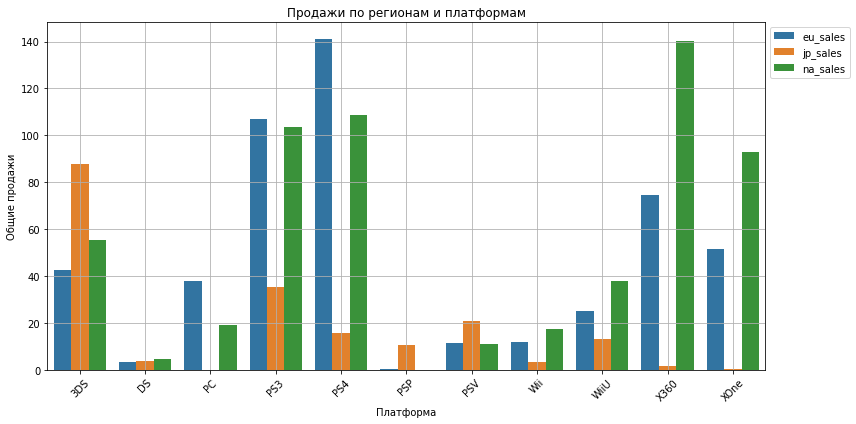

In [50]:
sales_pv = pd.pivot_table(actual_df, index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum').reset_index().melt(id_vars='platform', var_name='Region', value_name='Sales')

plt.figure(figsize=(12, 6))
sns.barplot(data=sales_pv, x='platform', y='Sales', hue='Region')

plt.title('Продажи по регионам и платформам')
plt.xlabel('Платформа')
plt.ylabel('Общие продажи')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

### Самые популярные жанры.

In [51]:
pd.pivot_table(actual_df, index='genre', values='na_sales',
                                        aggfunc='sum').sort_values('na_sales', ascending=False)

,na_sales
genre,
Action,177.84
Shooter,144.77
Sports,81.53
Role-Playing,64.00
Misc,38.19
Platform,25.38
Fighting,19.79
Racing,17.22
Adventure,8.92


In [52]:
pd.pivot_table(actual_df, index='genre', values='eu_sales',
                                        aggfunc='sum').sort_values('eu_sales', ascending=False)

,eu_sales
genre,
Action,159.34
Shooter,113.47
Sports,69.09
Role-Playing,48.53
Racing,27.29
Misc,26.32
Platform,21.41
Simulation,14.55
Fighting,10.79


In [53]:
pd.pivot_table(actual_df, index='genre', values='jp_sales',
                                        aggfunc='sum').sort_values('jp_sales', ascending=False)

,jp_sales
genre,
Role-Playing,65.44
Action,52.80
Misc,12.86
Simulation,10.41
Fighting,9.44
Shooter,9.23
Platform,8.63
Adventure,8.24
Sports,8.01


Рейтинг жанров:  
- Северная Америка: Action, Shooter, Sports, Role-Playing и Misc
- Европейский регион: Action, Shooter, Sports, Role-Playing и Racing
- Япония: Role-Playing, Action, Misc, Fighting и Shooter

1. Северная Америка:  
Action и Shooter — лидирующие жанры, отражая любовь североамериканских игроков к динамичным играм с экшеном и боевыми действиями.  
Sports занимает третье место, что свидетельствует о популярности спортивных симуляторов.  
Role-Playing (ролевые игры) также популярны, но уступают более экшен-ориентированным жанрам.  
Misc (разнообразные игры) на пятом месте, что указывает на определённый интерес к играм, которые сложно отнести к традиционным жанрам.  


2. Европейский регион:    
Как и в Северной Америке, Action и Shooter занимают лидирующие позиции, что говорит о схожих предпочтениях между двумя западными регионами.  
Sports на третьем месте, что подтверждает популярность спортивных игр и в Европе.  
Role-Playing также входит в топ-4, однако заметна любовь европейских игроков к Racing (гоночным играм), которые занимают пятую позицию, чего нет в Северной Америке.  


3. Япония:  
В отличие от западных рынков, в Японии на первом месте находятся Role-Playing (ролевые игры), что свидетельствует о глубокой привязанности японских игроков к этому жанру, который тесно связан с культурой японских игр (например, JRPG).
Action также популярен, занимая вторую позицию, но уступает ролевым играм.  
Misc и Fighting занимают третье и четвертое места соответственно, что отражает интерес к уникальным жанрам и бойцовским играм, что характерно для японского рынка.  
Shooter находится на пятом месте, что показывает меньший интерес к этому жанру по сравнению с западными рынками.  


4. Общий вывод:  
Action и Shooter — два самых популярных жанра как в Северной Америке, так и в Европе, что указывает на глобальный интерес к динамичным играм и шутерам в этих регионах.  
Sports также стабильно популярен Северной Америке и Европе.  
В Японии, в отличие от западных рынков, доминируют Role-Playing игры, что подчеркивает культурные различия в предпочтениях игроков. Японский рынок также выделяется сильной позицией жанров Fighting и Misc, которых нет в топах на Западе.  
Европейские игроки отличаются более выраженным интересом к гоночным играм (Racing), что не так заметно в других регионах.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [54]:
pd.pivot_table(actual_df, index='rating', values='na_sales',
                                        aggfunc='sum').sort_values('na_sales', ascending=False)

,na_sales
rating,
M,231.57
E,114.37
E10+,75.70
T,66.02


In [55]:
pd.pivot_table(actual_df, index='rating', values='eu_sales',
                                        aggfunc='sum').sort_values('eu_sales', ascending=False)

,eu_sales
rating,
M,193.96
E,113.03
E10+,55.37
T,52.96


In [56]:
pd.pivot_table(actual_df, index='rating', values='jp_sales',
                                        aggfunc='sum').sort_values('jp_sales', ascending=False)

,jp_sales
rating,
E,28.33
T,26.02
M,21.20
E10+,8.19


В регионах Северной Америки и Европы большая часть продаж приходится на рейтинг "М"(для взрослых), на втором по популярности "E"(для всех).  
В Японии же наоборот, рейтинг "E" занимает первое место, а рейтинг "М" третье. Второй по популярности рейтинг "T"(подростки).


**Промежуточный вывод:**
- В Северной Америке и Европе лидирами платформы являются PS4,Ps3,X360,XOne,3DS. В Японии 3DS,PS3,PSV,PS4,WiiU
- Самыми популярными жанрами являются Action и Shooter
- В регионах NA и EU ключевой аудторией являются взрослые. В Японии делают упор на подростков

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые?

- Нулевая гипотеза H0: пользовательские рейтинги Xbox One и PC одинаковые
- Альтернативная гипотеза H1: пользовательские рейтинги различаются
Метод проверки гипотезы о равенстве двух генеральных совокупностей.

In [57]:
alpha = 0.05

results = st.ttest_ind(
    actual_df.loc[(actual_df['platform'] == 'XOne') & (~actual_df['user_score'].isna()), 'user_score'],
    actual_df.loc[(actual_df['platform'] == 'PC') & (~actual_df['user_score'].isna()), 'user_score']
)

print('p-значение:', results.pvalue)

if  results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5535102819461235
Не получилось отвергнуть нулевую гипотезу


Пользователи XOne и PC в среднем ставят одинаковые оценки.

### Средние пользовательские рейтинги жанров Action и Sports  разные.

- Нулевая гипотеза H0: пользовательские рейтинги Action и Sports одинаковые
- Альтернативная гипотеза H1: пользовательские рейтинги различаются
Метод проверки гипотезы о равенстве двух генеральных совокупностей.

In [58]:
alpha = 0.05

results = st.ttest_ind(
    actual_df.loc[(actual_df['genre'] == 'Action') & (~actual_df['user_score'].isna()), 'user_score'],
    actual_df.loc[(actual_df['genre'] == 'Sports') & (~actual_df['user_score'].isna()), 'user_score']
)

print('p-значение:', results.pvalue)

if  results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.716101071226201e-26
Отвергаем нулевую гипотезу


Действительно, пользовательский рейтинги жанров Action и Sports различаются

## Вывод

База данных содержит информацию об играх, выпускавшихся с 1993 года. За это время игровой рынок претерпел значительные изменения. Ключевой переход произошёл в 2012-2013 годах с выходом консолей нового поколения. На сегодняшний день наиболее популярными платформами являются Xbox 360, Xbox One, PS3 и PS4. Для максимального охвата аудитории игра должна быть представлена на этих консолях, так как они обладают широкой пользовательской базой.

Хотя на рынке представлено огромное количество игр, большинство из них не пользуются популярностью. Условной границей, отделяющей успешные проекты, считаются продажи на уровне 200 тысяч копий. Преодоление этого порога свидетельствует о явном успехе. Факторы влияющие на популярность игры:

- Оценки критиков: Оценки пользователей не оказывают существенного влияния на продажи, в отличие от рецензий критиков. Наблюдается явная корреляция между высокими оценками критиков и коммерческим успехом. Трудно сказать, что первично — хвалят ли критики потенциально успешные игры или их отзывы способствуют росту популярности. Однако это стоит учитывать в маркетинговых стратегиях, поскольку положительные рецензии могут повлиять на успех продукта.

- Выбор жанра: Несмотря на доминирование экшен-игр, самые успешные продажи наблюдаются у шутеров, спортивных игр и платформеров. Вероятно, аудитория этих жанров более склонна к покупкам. Кроме того, конкуренция в этих категориях ниже, что повышает шансы игры быть замеченной на рынке.


Рекомендации для компании на 2017 год:

- Сосредоточить внимание на современных платформах (PS4, XOne, 3DS).
- Продавать популярные жанры: экшен, шутеры, спортивные и ролевые игры.
- Следить за аудиторией, большинство игр нацелены на игроков 17 лет и старше.
- Не забывать о распространении игр для ПК, включая порты с других платформ. Компьютер остаётся конкурентоспособным для игровой индустрии.